## Config

In [1]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
from spacy.vocab import Vocab
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import random
import itertools
from itertools import chain

from platform import python_version
print("VERSION: ", python_version()) # expect 3.7.0

# dirty spaCy error workaround:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

VERSION:  3.7.0


In [2]:
os_path = '/Users/milk/Desktop/git/'
forms_dir = os_path + 'InformedConsentForms/data/all_forms'

In [3]:
nlp = spacy.load('en')
nlp_larg = spacy.load('en_core_web_lg')

## Semantic Clues

In [4]:
##  taken from: 
# “I found great synonyms for ‘permission’ on the new Thesaurus.com!,”
# www.thesaurus.com. [Online]. Available: https://www.thesaurus.com/browse/permission. 
## [Accessed: 19-Feb-2019].

permission_bases = ["permission", 
                    "authorization", 
                    "authorize",
                    "consent",
                    "assent",
                    "permit",
                    "approve",
                    "grant",
                    "allow",
                    "certify"]

## add synonyms

In [5]:
def addWordNetSynsets(word_list):
    " add synsets to new list "
    updated_list = []
    
    for word in word_list:
        updated_list.append(word)
        synonyms = wordnet.synsets(word, 'v')
        synonyms = set(chain.from_iterable([word.lemma_names() for word in synonyms]))
        
        [updated_list.append(x) for x in synonyms if x not in updated_list]
        
    return updated_list
        
permission_extended = addWordNetSynsets(permission_bases)
print('num elements:', len(permission_extended))
# [print(x) for x in permission_extended]

num elements: 51


## build consent form data structure
get dict and dataframe from each consent form on file

#### todo: get metadata

In [6]:
def getData(directory):
    """ returns a dict with cleaned filenames, full paths,
    and text data in multiple formats from a dictionary
    of .txt files"""
    
    fileDictionary = {}
    fileID = 0
    
    # iterate through directory
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            
            fileID += 1
            filepath = subdir + os.sep + file
            
            if filepath.endswith('.txt'):
                wordList = [] # this will include duplicates and stop words
                cleanedFileName = ''.join(e for e in file if e.isalnum())[:-3] 
                
                # perform string operations on each file
                with open(filepath, 'r') as myfile:
                    data = myfile.read().replace('\n', ' ')       
                
                fileDictionary[fileID] = {}
                fileDictionary[fileID]['name'] = cleanedFileName
                fileDictionary[fileID]['path'] = filepath
                fileDictionary[fileID]['rawText'] = data
    
    return fileDictionary

# run the function and store to variable 
consent_dictionary = getData(forms_dir)

In [7]:
#test print statement
[print(k,v, '\n') for k,v in consent_dictionary[1].items()]

name TAMUHRPPInformedconsent 

path /Users/milk/Desktop/git/InformedConsentForms/data/all_forms/TAMU - HRPP Informed consent.txt 

rawText ﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APPROVAL  This document is a template for editing to delete highlighted and parenthetical sections.  Project Title:   You are invited to take part in a research study being conducted by Investigator Name, a researcher from Texas A&M University and funded by [name sponsor/funding source]. The information in this form is provided to help you decide whether or not to take part. If you decide to take part in the study, you will be asked to sign this consent form. If you decide you do not want to participate, there will be no penalty to you, and you will not lose any benefits you normally would have.  You may choose to withdraw from the study at any time without penalty.  NOTE:  If you are employed then it is your responsibility to work with your employer regarding work leave for participation in this study if d

[None, None, None]

In [8]:
def toDataFrame(fileDictionary):
    """ return pandas dataframe
    Note: expects input in nested dict format (output from getData)"""
    new_rows = []

    for key, value in fileDictionary.items():
        new_rows.append(value)
         
    df = pd.DataFrame(new_rows)
    return df

df = toDataFrame(consent_dictionary)

df.head(3)

,name,path,rawText
0,TAMUHRPPInformedconsent,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿NOT INTENDED FOR USE WITHOUT TAMU/BCD IRB APP...
1,PotomacPrimaryCarefluconsentform,/Users/milk/Desktop/git/InformedConsentForms/d...,PATIENT CONSENT FORM FOR SEASONAL INFLUENZA VA...
2,OSUScheduledDeliveryConsent,/Users/milk/Desktop/git/InformedConsentForms/d...,SCHEDULED DELIVERY: Today’s Date: Da...


## Random sampling to speed up development
This will be removed when we want to process the whole corpus

In [9]:
# comment out to run on whole corpus
n_samples = 50
df = df.sample(n=n_samples)

## add spacy object to dataframe

#### WARNING: this takes a long time,

In [10]:
def getDocObjects(row, field):
    " return spacy doc object"
#     # small nlp library
#     doc = nlp(str(row[field]).lower())

    # large library
    doc = nlp_larg(str(row[field]).lower())
    return doc

df['docOB'] = df.apply(lambda row:getDocObjects(row, 'rawText'),axis=1)

In [11]:
df['docOB'].head()

580    (﻿,        , template, consent, form, -, biome...
81     (state, of, illinois, -, migrant, &, seasonal,...
471    (mrn, :,  , orthopaedic, surgery,  , request, ...
686    (﻿informed, consent, for, clinical, research, ...
675    (pt, ., name, :, _, _, _, _, _, _, _, _, _, _,...
Name: docOB, dtype: object

## extract sentences

In [12]:
def getSentenceList(row, field):
    " return list of sents from doc object"
    sent_list = []
    
    # must operate on a spaCy doc object 
    for sent in row[field].sents:
#         print(dir(sent))
        sent_list.append(sent)
    
    return sent_list

df['sentList'] = df.apply(lambda row:getSentenceList(row, 'docOB'),axis=1)

In [13]:
def getWordListasString(row):
    """ return a list of words, including duplicates.
    NOTE: light cleaning on ingestion """
    wordList = [] 
    
    for word in row['rawText'].split():
        word = re.sub("[^a-zA-Z]+", " ", word).strip().lower()
        if not word == "":
            wordList.append(word)
            
    return " ".join(wordList)
        
df['cleanedText'] = df.apply(lambda row: getWordListasString(row),axis=1)

df.head(2)

,name,path,rawText,docOB,sentList,cleanedText
580,CFTemplateBiomed,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿ TEMPLATE CONSENT FORM - BIOMEDICAL ST...,"(﻿, , template, consent, form, -, biome...","[(﻿, , template, consent, form, -, biom...",template consent form biomedical study consent...
81,IllinoisParentalConsentDental,/Users/milk/Desktop/git/InformedConsentForms/d...,State of Illinois - Migrant & Seasonal Head St...,"(state, of, illinois, -, migrant, &, seasonal,...","[(state, of, illinois, -, migrant, &, seasonal...",state of illinois migrant seasonal head start ...


## preliminary permisison sentence extraction
look for sentences that have a word from the 'clues' list

# NOTE: DO WE WANT SENTENCE PAIRS? THREE SENTENCES?

In [14]:
def getPossiblePermissions(row, permissions_list):
    """ return list of sentences containing the 
    permissions words """
    
    sent_list = []
    
    for sent in row['sentList']:
        [sent_list.append(sent) for clue in\
             permission_extended if sent.text.__contains__(clue)]
                
    return sent_list

# here we only convert the first 10 rows to save time
df['permissionsStatements'] = df.apply(lambda row:getPossiblePermissions(row, permission_extended),axis=1)

In [15]:
for sent in df['permissionsStatements'][:10]:
    [print('sent:', x.text, '\n') for x in sent[:2]]

sent: ﻿        template consent form - biomedical study  consent to participate in research title of study (designate any subject sub-group here, e.g., "controls")   

sent: [give brief explanation of why study is being done, using one or two sentences written in clear language understandable to the target population].   

sent: state of illinois - migrant & seasonal head start department of human services  parental consent form for dental treatment date  child's name date of birth  your child is in need of some basic dental care. 

sent: state of illinois - migrant & seasonal head start department of human services  parental consent form for dental treatment date  child's name date of birth  your child is in need of some basic dental care. 

sent: orthopaedic surgery  request and consent to orthopaedic surgery and/or procedure  name 

sent: i understand that if i am given anesthesia or sedation analgesia there will be other risks. 

sent: ﻿informed consent for clinical research medsta

In [16]:
def getEstimatedPermissionDesnity(row):
    """ return proportion of sentence total that may
    be statements indicating perissions. Expect much noise. """
     
    return len(row['permissionsStatements'])/len(row['sentList'])
    
df['permissionDensity'] = df.apply(lambda row: getEstimatedPermissionDesnity(row),axis=1)

df.head(2)

,name,path,rawText,docOB,sentList,cleanedText,permissionsStatements,permissionDensity
580,CFTemplateBiomed,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿ TEMPLATE CONSENT FORM - BIOMEDICAL ST...,"(﻿, , template, consent, form, -, biome...","[(﻿, , template, consent, form, -, biom...",template consent form biomedical study consent...,"[(﻿, , template, consent, form, -, biom...",0.163311
81,IllinoisParentalConsentDental,/Users/milk/Desktop/git/InformedConsentForms/d...,State of Illinois - Migrant & Seasonal Head St...,"(state, of, illinois, -, migrant, &, seasonal,...","[(state, of, illinois, -, migrant, &, seasonal...",state of illinois migrant seasonal head start ...,"[(state, of, illinois, -, migrant, &, seasonal...",0.387097


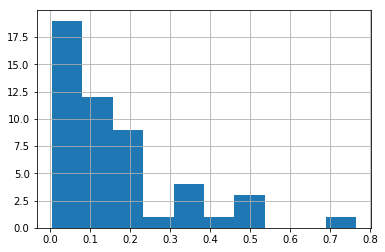

In [17]:
%matplotlib inline
df['permissionDensity'].hist()

## Important
this represents an important break away from the primary dataframe. here i start to work with list structures to create a list of possible permissions that is no longer tied to filenames

In [18]:
all_sents = []

for sentlist in df['sentList'].to_list():
    [all_sents.append(x) for x in sentlist]
    
all_permissions = []

for permlist in df['permissionsStatements'].to_list():
    [all_permissions.append(x) for x in permlist]

In [19]:
print('total rough draft permissions: ', len(all_permissions))
print('unique rough draft permissions: ', len(list(set(all_permissions))))

print('total rough draft sentences: ', len(all_sents))
print('unique rough draft sentences: ', len(list(set(all_sents))))

total rough draft permissions:  1479
unique rough draft permissions:  1137
total rough draft sentences:  15777
unique rough draft sentences:  15777


In [20]:
# remove duplucates
all_permissions = list(set(all_permissions))

## pair-wise similarity between our permission 'guesses' and remaining sentences
this is an important step so that we don't restrict ourselves to permission statements that contain the words we dreampt up

# WARNING: WILL NOT SCALE, need to fix


In [21]:
new_rows = []

for sent in all_sents:
    for perm in all_permissions:
        row = {
            'permission':perm,
            'sentence':sent,
            'similarity':sent.similarity(perm)
        }
        new_rows.append(row)

In [22]:
sf = pd.DataFrame(new_rows)
sf.head()

,permission,sentence,similarity
0,"(should, i, decide, , to, allow, extensive, g...","(﻿, , template, consent, form, -, biome...",0.851135
1,"(if, contrast, material, is, used, ,, you, may...","(﻿, , template, consent, form, -, biome...",0.803007
2,"(delete, this, first, page, of, information, i...","(﻿, , template, consent, form, -, biome...",0.842271
3,"(*, describe, the, methods, or, opportunities,...","(﻿, , template, consent, form, -, biome...",0.871770
4,"(you, will, be, given, a, study, medication, a...","(﻿, , template, consent, form, -, biome...",0.860484


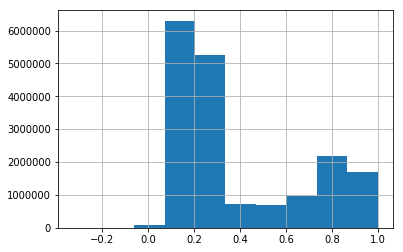

In [23]:
sf['similarity'].hist()

In [24]:
# reduce dataframe, aggregate by mean sim score (weak sents will balance out)
sf = sf.drop(columns=['permission'])
sf = sf.groupby(['sentence'], as_index=False).mean()

sf.head()

,sentence,similarity
0,"(﻿, , template, consent, form, -, biome...",0.831369
1,(﻿informed),0.000000
2,"(﻿emergency, use, of, an, investigational, dru...",0.850795
3,"(space, maintainer, /, appliance, release, spa...",0.720397
4,"(!, renée, laurion, goodspeed, ,, d.d.s, .)",0.131827


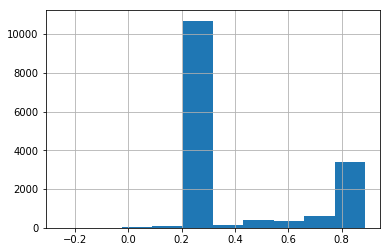

In [25]:
sf['similarity'].hist()

In [26]:
high_sim = sf[sf.similarity > .7]
candidates = high_sim['sentence'].to_list()

In [27]:
print('total rough draft candidates: ', len(candidates))
print('unique rough draft candidates: ', len(list(set(candidates))))

total rough draft candidates:  3870
unique rough draft candidates:  3870


In [28]:
[print('sent: ', x, '\n') for x in candidates[:5]]

sent:  ﻿        template consent form - biomedical study  consent to participate in research title of study (designate any subject sub-group here, e.g., "controls")   

sent:  ﻿emergency use of an investigational drug or device parental permission and authorization document  directions for use of this template:  • do not add the footer for the approval stamp.   

sent:  space maintainer/appliance release space maintainers help “hold space” for permanent teeth. 

sent:  ﻿ consent and authorization document for minimal risk research  note to the investigator:  informed consent is a process, not just a form. 

sent:   note to the investigator: informed consent is a process, not just a form. 



[None, None, None, None, None]

In [29]:
rough_draft_permissions = all_permissions + candidates

In [30]:
print('total rough draft candidates: ', len(rough_draft_permissions))
print('unique rough draft candidates: ', len(list(set(rough_draft_permissions))))

total rough draft candidates:  5007
unique rough draft candidates:  3936


In [31]:
rough_draft_permissions = list(set(rough_draft_permissions))

## print statements to file

In [32]:
# import csv
# import datetime
# today = str(datetime.date.today())

# file_path = 'statements-'+today+'.csv'
# print(file_path)

# with open(file_path, 'a') as outcsv:   
#     #configure writer to write standard csv file
#     writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
#     writer.writerow(['raw_text', 'clean_text'])
#     for perm in rough_draft_permissions:
#         #Write item to outcsv
#         raw_text = perm.text
#         clean_text = re.sub('\s+', ' ', re.sub('\W+',' ',\
#                                re.sub('[^A-Za-z0-9]+',' ', \
#                                       re.sub(r'\d+', " ", raw_text)))).strip()
#         writer.writerow([raw_text, clean_text])

# Annotations?

This is the point where injecting further information via annotations may be a good idea. This then would require in import of another local file and a small methods section.

## matrix representations

a few different matrix representations of the permissions sentence

In [33]:
def cleanPermissions(rough_draft_permissions):
    "string cleaning on permissions for td-idf ingestion"
    corpus = []
    
    
    for permission in rough_draft_permissions:
        cleanSentence = []
        for word in permission.text.split():
            word = re.sub("[^a-zA-Z]+", " ", word).strip().lower()
            if not word == "":
                cleanSentence.append(word)
        corpus.append(" ".join(cleanSentence))
    return corpus
            
corpus = cleanPermissions(rough_draft_permissions)

[print(x, '\n') for x in corpus[:10]]

should i decide to allow extensive genetic data from my sample to be made publically available the risk that i could be identified from this data is very slightly higher than if this data could only be shared between researchers 

if contrast material is used you may feel discomfort when it is injected given by xxx 

pain or swelling after this work is rare and usually minor 

what will i my child be asked to do in the study 

there are potential psychological risks that maybe associated with being approached about this study 

at that time either the research information not already in your medical record will be destroyed or your name and other identifying information will be removed from such study results 

you will be given a study medication and it will either contain name of drug or placebo pills with no medicine 

are not appropriate and should not be included in the document 

no patient will be denied an induction if medically indicated 

limited effectiveness of birth or sta

[None, None, None, None, None, None, None, None, None, None]

## NOTE: 
`minTermFrequencyThreshold = 0` will result in all possible n_grams and will not scale as input size or ngramSize increases. However, it is the most robust representation of the sentence, and is worth exploring for the time being...

In [37]:
ngramSize = 5
maxTermFrequencyThreshold = .8
minTermFrequencyThreshold = .001

def getTDIDFMatrix(corpus, ngram_range, max_df, min_df):
    """ return td-idf matrix and terms """
    
    tfidf_vectorizer = TfidfVectorizer(use_idf=True, 
                                       ngram_range=(1,ngram_range),
                                       max_df=max_df,min_df=min_df)
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
    terms = tfidf_vectorizer.get_feature_names()
    
    return tfidf_matrix, terms

# save to a variable 
tdidf_matrix, tdidf_terms = getTDIDFMatrix(corpus, 
                                           ngramSize, 
                                           maxTermFrequencyThreshold,
                                           minTermFrequencyThreshold)

# # print tests
# print('\nfirst few terms:')
# [print(" ", x) for x in tdidf_terms[:10]]

print('\nNumber of terms:', len(tdidf_terms))


Number of terms: 9242


In [38]:
sdf = pd.SparseDataFrame(tdidf_matrix, columns=tdidf_terms)

# here we add the sentences back in
sdf['sent'] = corpus

sdf.head()

,ability,ability to,ability to assess,ability to assess the,ability to assess the reading,able,able to,about,about any,about anything,...,your vein iv or you,your written,your your,your your child,your your child health,your your child health information,your your surviving,your your surviving child,yourself,zip
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.169637,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
permission_vectors = []

for perm in rough_draft_permissions:
#     print(perm.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])) # same features, different rows
#     print(perm.vector) # same shape
#     print(perm.vector_norm) # single value
#     print(perm.get_lca_matrix()) # differnt shapes
    permission_vectors.append(perm.vector)